In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
class ReplayBuffer:
    
    def __init__(self, size, input_shape):
        self.size = size
        self.counter = 0
        self.state_buffer = np.zeros((self.size, *input_shape), dtype=np.float32)
        self.action_buffer = np.zeros(self.size, dtype=np.int32)
        self.reward_buffer = np.zeros(self.size, dtype=np.float32)
        self.new_state_buffer = np.zeros((self.size, *input_shape), dtype=np.float32)
        self.terminal_buffer = np.zeros(self.size, dtype=np.bool_)

    def store_tuples(self, state, action, reward, new_state, done):
        idx = self.counter % self.size
        self.state_buffer[idx] = state
        self.action_buffer[idx] = action
        self.reward_buffer[idx] = reward
        self.new_state_buffer[idx] = new_state
        self.terminal_buffer[idx] = done
        self.counter += 1

    def sample_buffer(self, batch_size):
        max_buffer = min(self.counter, self.size)
        batch = np.random.choice(max_buffer, batch_size, replace=False)
        state_batch = self.state_buffer[batch]
        action_batch = self.action_buffer[batch]
        reward_batch = self.reward_buffer[batch]
        new_state_batch = self.new_state_buffer[batch]
        done_batch = self.terminal_buffer[batch]

        return state_batch, action_batch, reward_batch, new_state_batch, done_batch




class DuelingDQN(keras.Model):
    
    def __init__(self, num_actions, fc1, fc2):
        super(DuelingDQN, self).__init__()
        self.dense1 = Dense(fc1, activation='relu')
        self.dense2 = Dense(fc2, activation='relu')
        self.V = Dense(1, activation=None)
        self.A = Dense(num_actions, activation=None)

    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        V = self.V(x)
        A = self.A(x)
        avg_A = tf.math.reduce_mean(A, axis=1, keepdims=True)
        Q = (V + (A - avg_A))

        return Q, A


class Agent:
    def __init__(self, lr, discount_factor, num_actions, epsilon, batch_size, input_dim):
        self.action_space = [i for i in range(num_actions)]
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.epsilon_decay = 0.9995
        self.epsilon_final = 0.005
        self.update_rate = 120
        self.step_counter = 0
        self.buffer = ReplayBuffer(100000, input_dim)
        
        self.q_net = DuelingDQN(num_actions, 128, 128)
        self.q_target_net = DuelingDQN(num_actions, 128, 128)
        self.q_net.compile(optimizer=Adam(learning_rate=lr), loss='mse')
        self.q_target_net.compile(optimizer=Adam(learning_rate=lr), loss='mse')

    def store_tuple(self, state, action, reward, new_state, done):
        self.buffer.store_tuples(state, action, reward, new_state, done)

    def policy(self, observation):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            state = np.array([observation])
            _, actions = self.q_net(state)
            action = tf.math.argmax(actions, axis=1).numpy()[0]

        return action

    def train(self):
        if self.buffer.counter < self.batch_size:
            return
        if self.step_counter % self.update_rate == 0:
            self.q_target_net.set_weights(self.q_net.get_weights())

        state_batch, action_batch, reward_batch, new_state_batch, done_batch = \
            self.buffer.sample_buffer(self.batch_size)

        q_predicted, _ = self.q_net(state_batch)
        q_next, _ = self.q_target_net(new_state_batch)
        q_max_next = tf.math.reduce_max(q_next, axis=1, keepdims=True).numpy()
        q_target = np.copy(q_predicted)

        for idx in range(done_batch.shape[0]):
            target_q_val = reward_batch[idx]
            if not done_batch[idx]:
                target_q_val += self.discount_factor*q_max_next[idx]
            q_target[idx, action_batch[idx]] = target_q_val
        self.q_net.train_on_batch(state_batch, q_target)
        self.step_counter += 1

    
    def train_model(self, env, num_episodes, graph):

        self.scores, episodes, self.avg_scores, obj = [], [], [], []
        goal = 200
        f = 0
        txt = open("saved_networks.txt", "w")

        for i in range(num_episodes):
            done = False
            score = 0.0
            state = env.reset()
            while not done:
                action = self.policy(state)
                new_state, reward, done, _ = env.step(action)
                score += reward
                self.store_tuple(state, action, reward, new_state, done)
                state = new_state
                self.train()
            self.scores.append(score)
            obj.append(goal)
            episodes.append(i)
            avg_score = np.mean(self.scores[-100:])
            self.avg_scores.append(avg_score)
            print("Episode {0}/{1}, Score: {2} ({3}), AVG Score: {4}".format(i, num_episodes, score, self.epsilon,
                                                                             avg_score))
            self.epsilon *= self.epsilon_decay
            
        self.q_net.save(("saved_networks/duelingdqn_model{0}".format(f)))
        self.q_net.save_weights(("saved_networks/duelingdqn_model{0}/net_weights{0}.h5".format(f)))
        txt.write("Save {0} - Episode {1}/{2}, Score: {3} ({4}), AVG Score: {5}\n".format(f, i, num_episodes,
                                                                                                  score, self.epsilon,
                                                                                                  avg_score))
        print("Network saved")

        txt.close()
        if graph:
            df = pd.DataFrame({'x': episodes, 'Score': self.scores, 'Average Score': self.avg_scores, 'Solved Requirement': obj})

            plt.plot('x', 'Score', data=df, marker='', color='blue', linewidth=2, label='Score')
            plt.plot('x', 'Average Score', data=df, marker='', color='orange', linewidth=2, linestyle='dashed',
                     label='AverageScore')
            plt.plot('x', 'Solved Requirement', data=df, marker='', color='red', linewidth=2, linestyle='dashed',
                     label='Solved Requirement')
            plt.legend()
            plt.savefig('LunarLander_Train.png')

    
    def test(self, env, num_episodes, file_type, file, graph):
        if file_type == 'tf':
            self.q_net = tf.keras.models.load_model(file)
        elif file_type == 'h5':
            self.train_model(env, 5, False)
            self.q_net.load_weights(file)
        self.epsilon = 0.0
        self.scores, episodes, self.avg_scores, obj = [], [], [], []
        goal = 200
        score = 0.0
        for i in range(num_episodes):
            state = env.reset()
            done = False
            episode_score = 0.0
            while not done:
                env.render()
                action = self.policy(state)
                new_state, reward, done, _ = env.step(action)
                episode_score += reward
                state = new_state
            score += episode_score
            self.scores.append(episode_score)
            obj.append(goal)
            episodes.append(i)
            avg_score = np.mean(self.scores[-100:])
            self.avg_scores.append(avg_score)
            print("Episode {0}/{1}, Score: {2} ({3}), AVG Score: {4}".format(i, num_episodes, episode_score, self.epsilon,
                                                                             avg_score))

        if graph:
            df = pd.DataFrame({'x': episodes, 'Score': self.scores, 'Average Score': self.avg_scores, 'Solved Requirement': obj})

            plt.plot('x', 'Score', data=df, marker='', color='blue', linewidth=2, label='Score')
            plt.plot('x', 'Average Score', data=df, marker='', color='orange', linewidth=2, linestyle='dashed',
                     label='AverageScore')
            plt.plot('x', 'Solved Requirement', data=df, marker='', color='red', linewidth=2, linestyle='dashed',
                     label='Solved Requirement')
            plt.legend()
            plt.savefig('LunarLander_Test.png')

        env.close()
        
    def score(self):
        return self.scores, self.avg_scores
      



In [2]:
env = gym.make("LunarLander-v2")
spec = gym.spec("LunarLander-v2")
train = 0
test = 1
num_episodes = 100
graph = True

file_type = 'tf'
file = 'saved_networks/duelingdqn_model0'

Episode 0/100, Score: 235.17365583028328 (0.0), AVG Score: 235.17365583028328
Episode 1/100, Score: 253.20740865243945 (0.0), AVG Score: 244.19053224136138
Episode 2/100, Score: 267.3485156146601 (0.0), AVG Score: 251.90986003246095
Episode 3/100, Score: 281.29765463347076 (0.0), AVG Score: 259.2568086827134
Episode 4/100, Score: 265.6211585694019 (0.0), AVG Score: 260.5296786600511
Episode 5/100, Score: 278.5542681298939 (0.0), AVG Score: 263.5337769050249
Episode 6/100, Score: 283.33408137510827 (0.0), AVG Score: 266.3623918293225
Episode 7/100, Score: 233.3302136856388 (0.0), AVG Score: 262.23336956136205
Episode 8/100, Score: 275.40969502158316 (0.0), AVG Score: 263.6974057236088
Episode 9/100, Score: 238.83245002074077 (0.0), AVG Score: 261.21091015332206
Episode 10/100, Score: 239.9912143217266 (0.0), AVG Score: 259.28184689590427
Episode 11/100, Score: 252.15725800992425 (0.0), AVG Score: 258.6881311554059
Episode 12/100, Score: 282.5316761649997 (0.0), AVG Score: 260.5222500022

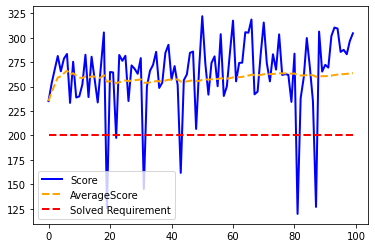

In [3]:
duelingdqn_agent = Agent(lr=0.00075, discount_factor=0.99, num_actions=4, epsilon=1.0, batch_size=64, input_dim=[8])

if train and not test:
    duelingdqn_agent.train_model(env, num_episodes, graph)
else:
    duelingdqn_agent.test(env, num_episodes, file_type, file, graph)

In [4]:
duelingdqn_agent.score()

([-82.9648642155326,
  -472.05028159557924,
  -280.2247328249254,
  -196.57499483864862],
 [-82.9648642155326,
  -277.5075729055559,
  -278.4132928786791,
  -257.95371836867145])